In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import os
import pandas as pd
import pickle
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


## 最小データ数の取得用関数
最もサンプル数の少ないデータの数を取得

In [0]:
def search_min_data_num(num_classes):
    # init
    dict_num = []

    for i in range(num_classes):
        file_name = "/content/drive/My Drive/Colab Notebooks/data/" + TRAIN_DATA_FILES[i] + '.csv'
        data_set = pd.read_csv(file_name, header=None)
        
        num_data_set = len(data_set)
        dict_num.append(num_data_set)
        
        print(TRAIN_DATA_FILES[i], num_data_set, sep=': ')

    min_data_num = min(dict_num)
    print('\n')
    print("min_data_num:", min_data_num)
    
    return min_data_num

## Define

In [67]:
TRAIN_DATA_FILES = ['cross','dead', 'left', 'right', 'straight', 'threeway']
#TRAIN_DATA_FILES = ['cross', 'right', 'left']
# NUM_CLASSES = 6
NUM_CLASSES = len(TRAIN_DATA_FILES)
num_data_set = search_min_data_num(NUM_CLASSES)
REPLACE_NAN = 0.0

epochs = 120
batch_size = 100


cross: 688
dead: 4377
left: 2590
right: 1852
straight: 3952
threeway: 10048


min_data_num: 688


## 学習データ数の調節用関数  
データ読み込み時、それぞれのラベルの学習データの内、最も数の少ないものに合わせる

In [0]:
def adjust_data_num(num_class):
    # header = 列名
    file_name = "/content/drive/My Drive/Colab Notebooks/data/" + TRAIN_DATA_FILES[num_class] + '.csv'
    data_set = pd.read_csv(file_name, header=None)

    return data_set.sample(num_data_set)

## 学習データ読み込み用関数

In [0]:
def split_data():
    files = os.listdir('/content/drive/My Drive/Colab Notebooks/data')
    X = []
    Y = []
    all_data_set = []
    labels = []


    for i in range(NUM_CLASSES):
        try:
            data_set = adjust_data_num(i)
            all_data_set.append(data_set)

            # one_hot_vectorを作りラベルとして追加
            tmp = np.zeros((num_data_set, NUM_CLASSES))
            tmp[:, i] = 1
            labels.append(tmp)
        except pd.io.common.EmptyDataError:
            print("ERROR: {} is empty".format(file_name))

    X = pd.concat(all_data_set)
    # replace Nan with 'REPLACE_NAN'
    X = X.fillna(REPLACE_NAN)
    Y = np.concatenate(labels, axis=0)

#    _, DIM_input_data = data_set.shape

    X_train, X_validation_and_test, Y_train, Y_validation_and_test = train_test_split(X, Y,train_size=0.6, test_size=0.4)
    X_validation, X_test, Y_validation, Y_test = train_test_split(X_validation_and_test, Y_validation_and_test, train_size=0.5, test_size=0.5)

    return X_train, X_validation, X_test, Y_train, Y_validation, Y_test

## ヒートマップ描画用関数

In [0]:
def print_cmx(y_true, predict, index=None):
    true_classes = np.argmax(y_true,1)

    cmx_data = confusion_matrix(true_classes, predict)

    df_cmx = pd.DataFrame(cmx_data, index=index, columns=index)

    plt.figure(figsize = (10,7))
    sns.heatmap(df_cmx, annot=True)
    plt.show()

## グラフプロット用関数

In [0]:
def plt_result(epochs, history):
    plt.plot(range(1, epochs+1), history.history['acc'], label="training")
    plt.plot(range(1, epochs+1), history.history['val_acc'], label="validation")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    predict_classes = model.predict_classes(X_test, batch_size=32)
    print_cmx(Y_test, predict_classes, TRAIN_DATA_FILES)

# 学習実行

###### データ読み込み

In [0]:
X_train, X_validation, X_test, Y_train, Y_validation, Y_test = split_data()
_, DIM_input_data = X_train.shape

###### 学習

## ネットワーク設計
現在  
input(726) -  
<span>　</span>mid_lay1(dropout1) - mid_lay2(dropout2) -  
<span>　　</span>output(6)

In [0]:
# 726-800-6 = 3層のネットワーク
DIM_HIDDEN1 = 1000

RATIO_DROP_OUT1 = 0.25

model = Sequential()
model.add(Dense(DIM_HIDDEN1, input_dim = DIM_input_data, activation='relu'))
model.add(Dropout(RATIO_DROP_OUT1))

model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(X_validation, Y_validation))

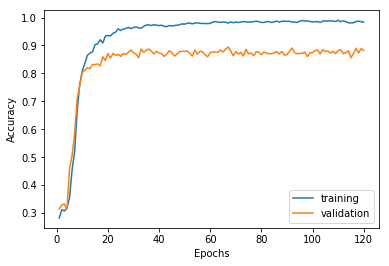

Test loss: 0.03281551833573467
Test accuracy: 0.8849878925965426


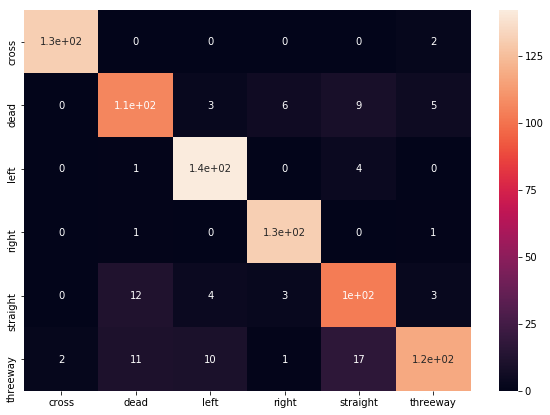

In [71]:
plt_result(epochs, history)

In [0]:
# 726-800-800-800-6 = 5層のネットワーク
DIM_HIDDEN1 = 1000
DIM_HIDDEN2 = 1000
DIM_HIDDEN3 = 1000

RATIO_DROP_OUT1 = 0.25
RATIO_DROP_OUT2 = 0.25
RATIO_DROP_OUT3 = 0.25

model = Sequential()
model.add(Dense(DIM_HIDDEN1, input_dim = DIM_input_data, activation='relu'))
model.add(Dropout(RATIO_DROP_OUT1))

model.add(Dense(DIM_HIDDEN2, activation='relu'))
model.add(Dropout(RATIO_DROP_OUT2))

model.add(Dense(DIM_HIDDEN3, activation='relu'))
model.add(Dropout(RATIO_DROP_OUT3))

model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(X_validation, Y_validation))

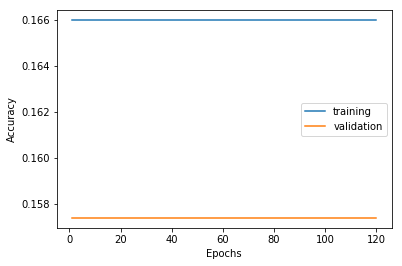

Test loss: 0.27401130807024515
Test accuracy: 0.177966101785116


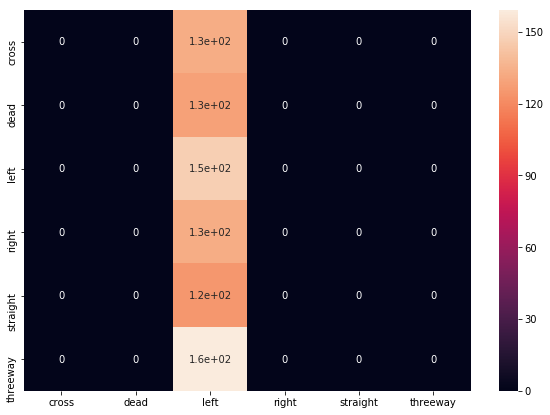

In [73]:
plt_result(epochs, history)

In [0]:
# 726-800-6 = 3層のネットワーク
DIM_HIDDEN1 = 1000

RATIO_DROP_OUT1 = 0.25

model = Sequential()
model.add(Dense(DIM_HIDDEN1, input_dim = DIM_input_data, activation='relu'))
model.add(Dropout(RATIO_DROP_OUT1))

model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(X_validation, Y_validation))

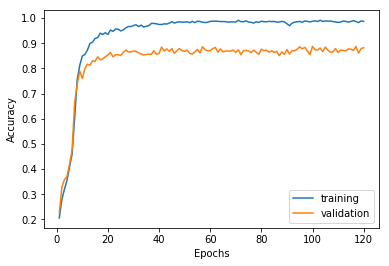

Test loss: 0.030943966581154676
Test accuracy: 0.8910411613616759


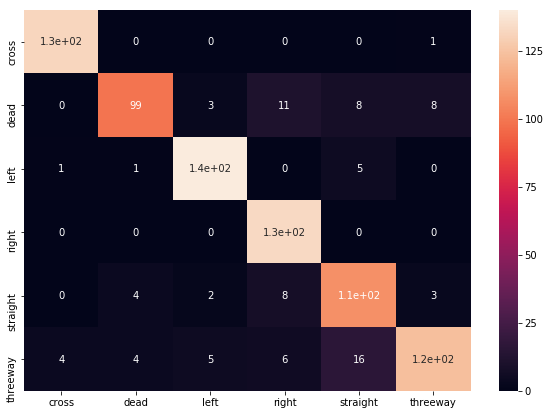

In [75]:
plt_result(epochs, history)

In [0]:
# 726-800-800-800-6 = 5層のネットワーク
DIM_HIDDEN1 = 1000
DIM_HIDDEN2 = 1000
DIM_HIDDEN3 = 1000

RATIO_DROP_OUT1 = 0.25
RATIO_DROP_OUT2 = 0.25
RATIO_DROP_OUT3 = 0.25

model = Sequential()
model.add(Dense(DIM_HIDDEN1, input_dim = DIM_input_data, activation='relu'))
model.add(Dropout(RATIO_DROP_OUT1))

model.add(Dense(DIM_HIDDEN2, activation='relu'))
model.add(Dropout(RATIO_DROP_OUT2))

model.add(Dense(DIM_HIDDEN3, activation='relu'))
model.add(Dropout(RATIO_DROP_OUT3))

model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(X_validation, Y_validation))

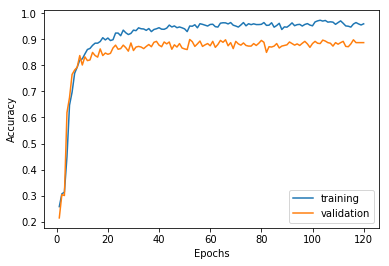

Test loss: 0.03142910392968476
Test accuracy: 0.8874092011128442


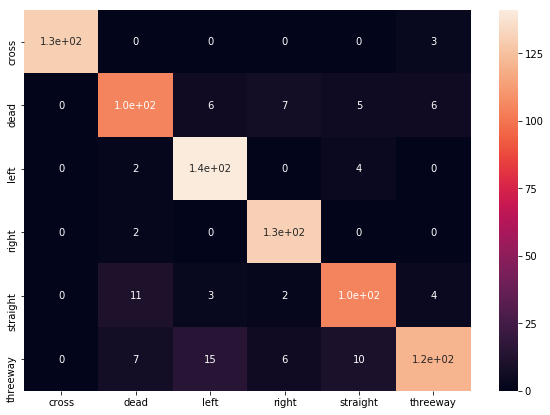

In [77]:
plt_result(epochs, history)

In [0]:
# 726-800-800-800-6 = 5層のネットワーク
DIM_HIDDEN1 = 1000
DIM_HIDDEN2 = 1000

RATIO_DROP_OUT1 = 0.25
RATIO_DROP_OUT2 = 0.25

model = Sequential()
model.add(Dense(DIM_HIDDEN1, input_dim = DIM_input_data, activation='relu'))
model.add(Dropout(RATIO_DROP_OUT1))

model.add(Dense(DIM_HIDDEN2, activation='relu'))
model.add(Dropout(RATIO_DROP_OUT2))

model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(X_validation, Y_validation))

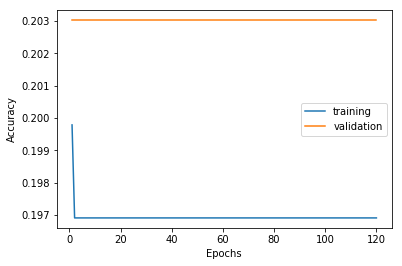

Test loss: 0.31749461079519203
Test accuracy: 0.20626349895227034


In [0]:
plt_result(epochs, history)